In [1]:
import numpy as np
import os
from tifffile import imread, imsave

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

from scipy.ndimage.morphology import distance_transform_edt
import itk

from aicssegmentation.core.visual import blob2dExplorer_single, random_colormap
from aicssegmentation.core.seg_dot import dot_2d
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.pre_processing_utils import intensity_normalization, suggest_normalization_param, edge_preserving_smoothing_3d

In [2]:
dataDir = r'hackathon-data/Segmentation/Harvard_Lung/LUNG-1-LN/'

In [26]:
im_path = os.path.join(dataDir,'LUNG-1-LN_40X_1.tif')

In [76]:
img = imread(im_path)
print(img.dtype)
# print(img[0,0])

uint16
0


### Norm info for the whole image

In [46]:
suggest_normalization_param(img)

mean intensity of the stack: 20753.924487085565
the standard deviation of intensity of the stack: 20829.052286087455
0.9999 percentile of the stack intensity is: 65535.0
minimum intensity of the stack: 0
maximum intensity of the stack: 65535
suggested upper range is 2.0, which is 62412.02905926047
suggested lower range is 0.5, which is 10339.398344041838
So, suggested parameter for normalization is [0.5, 2.0]
To further enhance the contrast: You may increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions)
To slightly reduce the contrast: You may decrease the first value, or increase the second value


(10101, 9666)


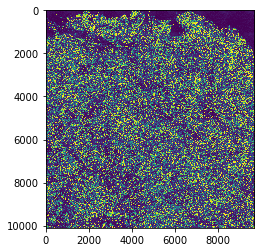

In [121]:
print(img.shape)
plt.imshow(img)

In [48]:
img = img[1000:1512,3000:3512]

In [49]:
img.shape #(512, 512)

(512, 512)

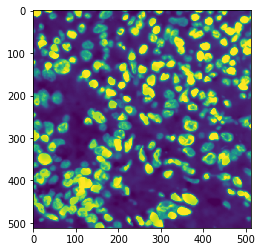

In [40]:
plt.imshow(img)

In [50]:
suggest_normalization_param(img)
# img.min()

mean intensity of the stack: 22418.06343460083
the standard deviation of intensity of the stack: 20944.790982222265
0.9999 percentile of the stack intensity is: 65535.0
minimum intensity of the stack: 0
maximum intensity of the stack: 65535
suggested upper range is 2.0, which is 64307.64539904536
suggested lower range is 1.0, which is 1473.2724523785655
So, suggested parameter for normalization is [1.0, 2.0]
To further enhance the contrast: You may increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions)
To slightly reduce the contrast: You may decrease the first value, or increase the second value


In [44]:
img.mean()

22418.06343460083

In [33]:
img_norm = intensity_normalization(img, [0.5, 1.5])

intensity normalization: normalize into [mean - 0.5 x std, mean + 1.5 x std] 
intensity normalization completes


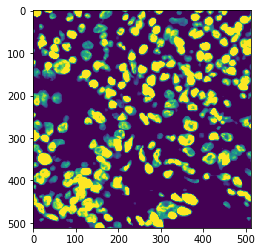

In [34]:
plt.imshow(img_norm)

In [35]:
img_smooth = edge_preserving_smoothing_3d(img_norm)

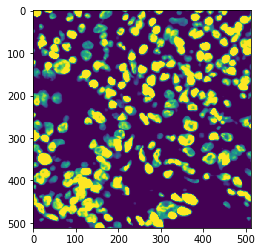

In [36]:
plt.imshow(img_smooth)

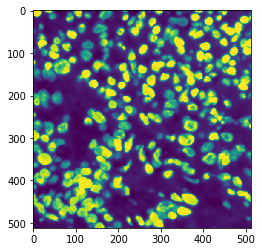

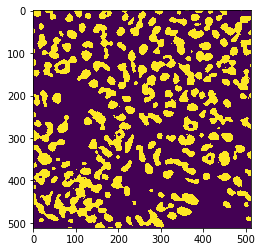

In [17]:
interact(blob2dExplorer_single, im=fixed(img_smooth), \
         sigma=widgets.FloatRangeSlider(value=[1,5], min=1, max=11,step=1,continuous_update=False),  \
         th=widgets.FloatSlider(value=0.05,min=0.01, max=0.5, step=0.01,continuous_update=False));

In [18]:
img_dot_detection = dot_2d(img_smooth, 5)

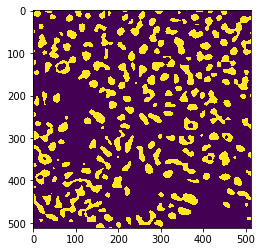

In [19]:
pre_mask = img_dot_detection>0.1
plt.imshow(pre_mask)

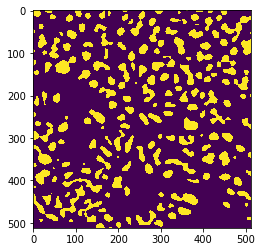

In [52]:
refined_mask = hole_filling(pre_mask, 1, 400)
plt.imshow(refined_mask)

In [53]:
# watershed without seed in tik
watershed_map = -1*distance_transform_edt(refined_mask)
itk_raw = itk.GetImageFromArray(watershed_map.astype(np.float32))
watershed_result = itk.watershed_image_filter(itk_raw, threshold=0.01, level=0.28)
new_label = itk.GetArrayFromImage(watershed_result)

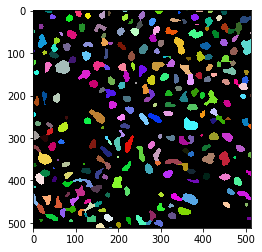

In [54]:
plt.imshow(new_label, cmap=random_colormap())

In [139]:
# patchSize = 256
# x = img.shape[0]
# y = img.shape[1]
# xres = img.shape[0]%256
# print(xres)
# yres = img.shape[1]%256
# print(yres)
# xpad1 = np.int(np.ceil(xres/2))
# xpad2 = xres-xpad1
# ypad1 = np.int(np.ceil(yres/2))
# ypad2 = yres-ypad1
# print(ypad1, ypad2)
# newImg = np.pad(img, [(xpad1,xpad2), (ypad1,ypad2)], mode='constant')
# print(newImg.shape)
# # # print(x//patchSize)

# patch_count = 0
# trainPatch = np.zeros([1520, patchSize, patchSize]).astype(img.dtype)
# for i in np.arange(0, newImg.shape[0],step=int(patchSize)):
#     for j in np.arange(0, newImg.shape[1],step=int(patchSize)):
#       print(i,j)
#       patch = newImg[i:i+patchSize,j:j+patchSize]
#       trainPatch[patch_count,:,:] = patch
# #       print(i,j,patch.shape)
#       patch_count += 1

# # if (xres)%2==1:
# # newImg = np.pad(img, [(59,58), (97,97)], mode='constant')
# # print(trainPatch.shape)

In [127]:
10%3

1

In [130]:
np.ceil(194/2)

97.0